# Beating the [DeepFood Paper](https://arxiv.org/abs/1606.05675) with Transfer Learning

## Introduction

In this notebook, we will be using the [Food101 Dataset](https://www.tensorflow.org/datasets/catalog/food101) from TensorFlow Datasets to train a model that can classify images of food into 101 different classes. We will be using the [EfficientNetB4](https://arxiv.org/pdf/1905.11946.pdf) model as our base model, and will be fine-tuning it to achieve better results. We will also be using mixed-precision training to speed up the training process, along with the use of efficient pre-fetched data pipelines for the same.

## Contents
- [Import libraries](#Import-libraries)
- [Check for GPU](#Check-for-GPU)
- [Load Food101 Dataset from TensorFlow Datasets](#Load-Food101-Dataset-from-TensorFlow-Datasets)
- [Create pre-processing function](#Create-pre-processing-function)
- [Create a good data input pipeline](#Create-a-good-data-input-pipeline)
- [Create Model Checkpoint Callback](#Create-Model-Checkpoint-Callback)
- [Setup Mixed-Precision training](#Setup-Mixed-Precision-training)
- [Create a data augmentation layer](#Create-a-data-augmentation-layer)
- [Create a Feature-Extraction model from the EfficientNetB4 base model](#Create-a-Feature-Extraction-model-from-the-EfficientNetB4-base-model)
- [Compile the model](#Compile-the-model)
- [Fit the model](#Fit-the-model)
- [Evaluate the Feature-Extraction model](#Evaluate-the-Feature-Extraction-model)
- [Fine-tune the model, unfreeze final 90 layers](#Fine-tune-the-model,-unfreeze-final-90-layers)
- [Evaluate the fine-tuned model](#Evaluate-the-fine-tuned-model)
- [Build and Plot the Confusion Matrix](#Build-and-Plot-the-Confusion-Matrix)
- [Display additional metrics](#Display-additional-metrics)
- [Conclusion](#Conclusion)

## Objective
The primary objective of this notebook is to beat the results obtained by the [DeepFood Paper](https://arxiv.org/abs/1606.05675) using the same dataset. The paper achieved a top-1 accuracy of 77.4% and a top-5 accuracy of 93.2%. We will be using the same metrics to evaluate our model.

## Import libraries

In [1]:
# We intend to shut down all warnings, and non-essential information in this notebook from TensorFlow
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow_datasets as tfds

In [3]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Check for GPU

In [4]:
!nvidia-smi

Tue Dec 26 19:45:11 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   46C    P8               6W /  60W |    292MiB /  4096MiB |     24%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
tf.config.list_logical_devices('GPU')

[LogicalDevice(name='/device:GPU:0', device_type='GPU')]

## Load [**Food101 Dataset**](https://www.tensorflow.org/datasets/catalog/food101) from TensorFlow Datasets

In [6]:
!pip install tensorflow-datasets

In [7]:
'food101' in tfds.list_builders()

True

In [8]:
(train_ds, test_ds), ds_info = tfds.load('food101',
                                         split=['train', 'validation'],
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True)

### Find label and image sizes from the metadata

In [9]:
print(ds_info)
print(ds_info.features['image'], ds_info.features['label'])

tfds.core.DatasetInfo(
    name='food101',
    full_name='food101/2.0.0',
    description="""
    This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.
    """,
    homepage='https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/',
    data_dir='/home/anikate/tensorflow_datasets/food101/2.0.0',
    file_format=tfrecord,
    download_size=4.65 GiB,
    dataset_size=4.77 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <Spli

In [10]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
class_names = ds_info.features['label'].names

### See image shapes, and tensors

In [12]:
ds_element = train_ds.take(1)
ds_element

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
element = next(iter(ds_element))
image = element[0]
label = element[1]

print(image.shape, label)

print(image)
print(tf.reduce_min(image), tf.reduce_max(image))

(512, 512, 3) tf.Tensor(23, shape=(), dtype=int64)
tf.Tensor(
[[[189 165 121]
  [185 161 117]
  [181 157 113]
  ...
  [111  72  33]
  [103  64  25]
  [ 94  55  16]]

 [[186 162 118]
  [183 159 115]
  [180 156 112]
  ...
  [122  83  40]
  [113  74  31]
  [105  66  23]]

 [[180 156 112]
  [178 154 110]
  [177 153 109]
  ...
  [132  94  45]
  [124  87  35]
  [120  83  31]]

 ...

 [[207 204 159]
  [205 201 154]
  [204 196 147]
  ...
  [231 225 191]
  [231 225 189]
  [231 226 188]]

 [[207 204 159]
  [205 201 154]
  [204 196 147]
  ...
  [230 224 190]
  [230 224 188]
  [229 223 187]]

 [[206 203 158]
  [204 200 153]
  [203 195 146]
  ...
  [229 223 189]
  [228 222 186]
  [228 222 186]]], shape=(512, 512, 3), dtype=uint8)
tf.Tensor(0, shape=(), dtype=uint8) tf.Tensor(255, shape=(), dtype=uint8)


## Visualize the data

In [14]:
def plot_image(image):
    plt.imshow(image)
    plt.title(class_names[label.numpy()])
    plt.axis(False)

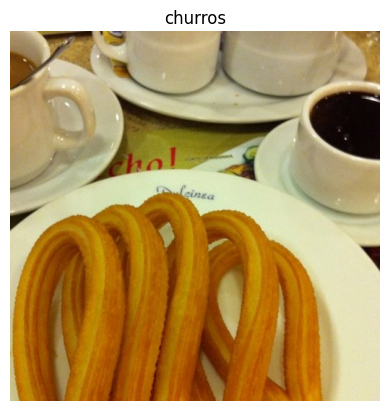

In [15]:
plot_image(image)

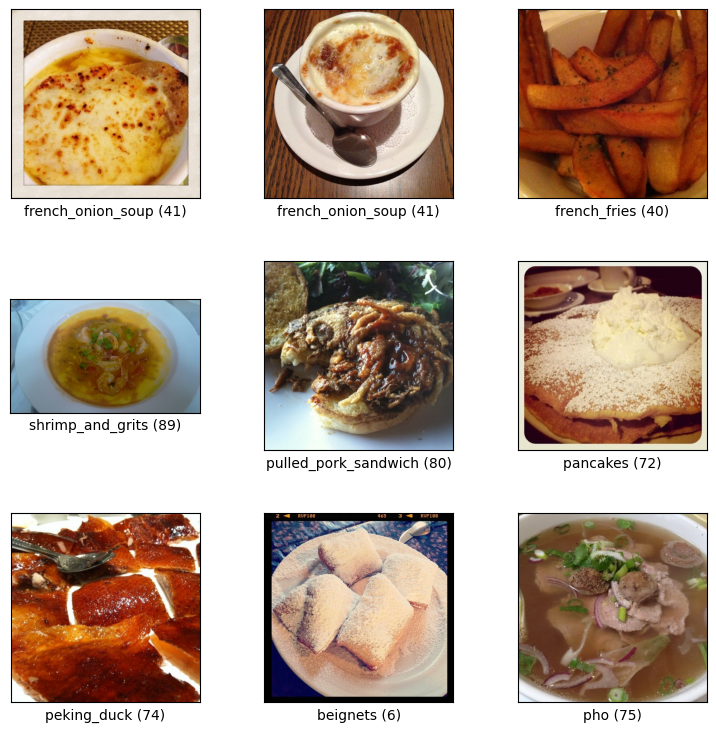

In [16]:
fig = tfds.show_examples(train_ds, ds_info)

## Create pre-processing function

In [17]:
def preprocess(image, label):
    print(image.shape)
    image = tf.image.resize(image, (256, 256))
    print(image.shape)
    image = tf.cast(image, dtype=tf.float32)

    return image, label

### Analyze pre-processed images

In [18]:
preprocessed_img = preprocess(image, label)
preprocessed_img

(512, 512, 3)
(256, 256, 3)


(<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[185.75, 161.75, 117.75],
         [180.5 , 156.5 , 112.5 ],
         [182.75, 159.75, 117.75],
         ...,
         [135.25,  95.75,  57.25],
         [119.25,  80.25,  39.75],
         [103.75,  64.75,  23.75]],
 
        [[176.75, 152.75, 108.75],
         [176.  , 152.  , 108.  ],
         [179.  , 154.  , 113.  ],
         ...,
         [152.75, 116.75,  67.  ],
         [139.75, 102.5 ,  49.75],
         [128.5 ,  92.  ,  37.  ]],
 
        [[173.  , 149.  , 105.  ],
         [174.  , 150.  , 106.  ],
         [175.5 , 150.5 , 109.5 ],
         ...,
         [147.5 , 112.75,  54.5 ],
         [148.75, 112.75,  51.25],
         [145.5 , 110.25,  46.75]],
 
        ...,
 
        [[202.5 , 198.5 , 151.  ],
         [202.  , 195.  , 143.75],
         [203.5 , 194.5 , 140.75],
         ...,
         [231.5 , 225.5 , 191.5 ],
         [230.  , 224.25, 188.25],
         [229.  , 224.  , 186.  ]],
 
        [[204.5 , 201

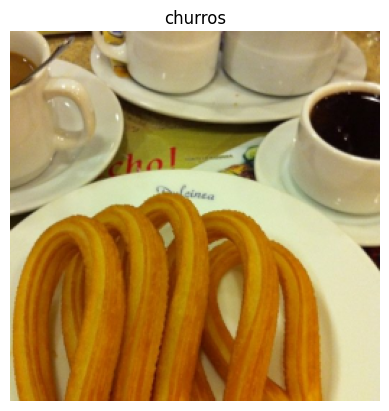

In [19]:
plot_image(preprocessed_img[0] / 255)

## Create a good data input pipeline

In [20]:
tf.data.AUTOTUNE

-1

### Map the pre-processing function to the training data

In [21]:
train_data = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_data

(None, None, 3)
(256, 256, 3)


<_ParallelMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

### Shuffle the training data, batch and pre-fetch

In [22]:
train_data = train_data.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
test_data = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_data

(None, None, 3)
(256, 256, 3)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [24]:
# check the shapes and objects that the datasets now have
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create Model Checkpoint Callback

In [25]:
def create_model_checkpoint_callback(
        model_name,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
):
    """
    Creates a ModelCheckpoint callback to save the model after every epoch.
    
    :param model_name: Name of the model
    :param monitor: Metric to monitor for saving the model
    :param mode: One of {auto, min, max}. If `save_best_only=True`, the decision to overwrite the current save file is
        made based on either the maximization or the minimization of the monitored quantity. For `val_acc`, this should
        be `max`, for `val_loss` this should be `min`, etc. In `auto` mode, the direction is automatically inferred
        from the name of the monitored quantity.
    :param save_best_only: If `save_best_only=True`, the latest best model according to the quantity monitored will not
        be overwritten.
    :return: tf.keras.callbacks.ModelCheckpoint
    """
    from tensorflow.keras.callbacks import ModelCheckpoint

    return ModelCheckpoint(
        filepath=os.path.join(model_name, 'checkpoint'),
        monitor=monitor,
        save_best_only=save_best_only,
        verbose=1,
        mode=mode,
    )

In [26]:
model_checkpoint_callback = create_model_checkpoint_callback(
    model_name='model',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
)

model_checkpoint_callback

## Setup Mixed-Precision training

In [27]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

print('Compute dtype: %s' % mixed_precision.global_policy().compute_dtype)
print('Variable dtype: %s' % mixed_precision.global_policy().variable_dtype)

Compute dtype: float16
Variable dtype: float32


## Create a data augmentation layer

In [28]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomWidth(0.2),
])

In [29]:
augmented_img = data_augmentation(tf.expand_dims(preprocessed_img[0], axis=0))

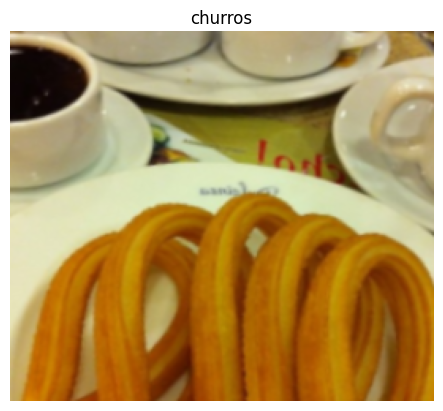

In [30]:
plot_image(tf.cast(tf.squeeze(augmented_img / 255, 0), dtype=tf.float32))

## Create a Feature-Extraction model from the [EfficientNetB4](https://arxiv.org/pdf/1905.11946.pdf) base model

In [31]:
base_model = tf.keras.applications.efficientnet.EfficientNetB4(
    input_shape=(256, 256, 3),
    include_top=False,
)
base_model.trainable = False
base_model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0

In [32]:
inputs = tf.keras.Input(shape=(256, 256, 3))

# the model performed better without data augmentation, and hence the layer is commented out
# x = data_augmentation(inputs)

# x = base_model(x, training=False)
x = base_model(inputs, training=False)

x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation('softmax', dtype=tf.float32)(x)

model = tf.keras.Model(inputs, outputs)

In [33]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 17854916 (68.11 MB)
Trainable params: 181093 (7

In [34]:
# compile the model

model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [35]:
# fit the model

initial_epochs = 4

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=initial_epochs,
    callbacks=[
        model_checkpoint_callback,
    ],
    steps_per_epoch=len(train_data),
    validation_steps=0.15 * len(test_data),  # validate on 15% of the test data to save time
)

Epoch 1/4
   2/2368 [..............................] - ETA: 5:12 - loss: 4.6489 - accuracy: 0.0000e+00   

I0000 00:00:1703600213.781653   56511 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2368/2368 [==============================] - ETA: 0s - loss: 1.7029 - accuracy: 0.5782
Epoch 1: val_accuracy improved from -inf to 0.69485, saving model to model/checkpoint
2368/2368 [==============================] - 359s 148ms/step - loss: 1.7029 - accuracy: 0.5782 - val_loss: 1.1762 - val_accuracy: 0.6949
Epoch 2/4
2367/2368 [============================>.] - ETA: 0s - loss: 1.2241 - accuracy: 0.6799
Epoch 2: val_accuracy improved from 0.69485 to 0.71822, saving model to model/checkpoint
2368/2368 [==============================] - 350s 148ms/step - loss: 1.2240 - accuracy: 0.6799 - val_loss: 1.0650 - val_accuracy: 0.7182
Epoch 3/4
2367/2368 [============================>.] - ETA: 0s - loss: 1.0820 - accuracy: 0.7140
Epoch 3: val_accuracy improved from 0.71822 to 0.72847, saving model to model/checkpoint
2368/2368 [==============================] - 351s 148ms/step - loss: 1.0821 - accuracy: 0.7140 - val_loss: 1.0222 - val_accuracy: 0.7285
Epoch 4/4
2367/2368 [=======================

## Evaluate the Feature-Extraction model

In [36]:
# evaluate on the entire test set
loss, accuracy = model.evaluate(test_data)
loss, accuracy

790/790 [==============================] - 100s 126ms/step - loss: 1.0098 - accuracy: 0.7272


(1.0098247528076172, 0.7271683216094971)

In [37]:
def plot_curves(history, figsize=(12, 5)):
    """
    Plots the loss and accuracy curves for the training and validation set.
    Creates two plots, one for loss and another for accuracy, and displays them side by side.
    
    **WARNING: This function assumes that the history object contains the loss and accuracy values for both training and validation sets.**
    
    :param history: History object obtained from fitting a tf.keras.Model 
    :param figsize: tuple, size of the figure (width, height)
    :return: None 
    """

    import matplotlib.pyplot as plt

    plt.figure(figsize=figsize)

    plt.subplot(1, 2, 1)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plt.plot(acc, label='Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(loss, label='Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()

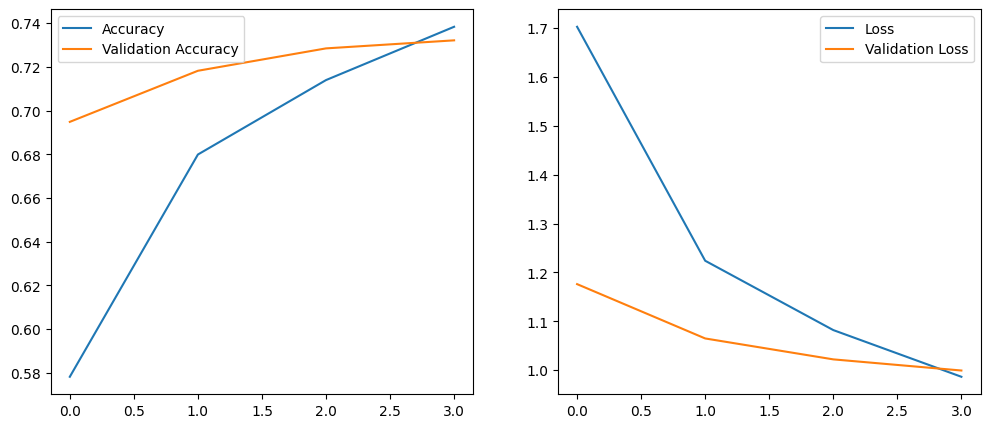

In [38]:
plot_curves(history)

In [39]:
# save the model# fit the model
model.save('model')

## Fine-tune the model, unfreeze final 90 layers

In [40]:
base_model.trainable = True

for layer in base_model.layers[:-90]:
    layer.trainable = False

base_model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 256, 256, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 256, 256, 3)          0         ['normalization[0

In [41]:
model.compile(
    optimizer='Adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               181093    
                                                                 
 activation (Activation)     (None, 101)               0         
                                                                 
Total params: 17854916 (68.11 MB)
Trainable params: 9650921 (

In [42]:
# use early stopping and learning rate reduction callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

fine_tune_epochs = initial_epochs + 6

history_fine_tune = model.fit(
    train_data,
    epochs=fine_tune_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=test_data,
    validation_steps=0.15 * len(test_data),
    steps_per_epoch=len(train_data),
    callbacks=[
        EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            verbose=1,
            mode='max',
        ),
        ReduceLROnPlateau(
            factor=0.2,
            patience=2,
            verbose=1,
            monitor='val_accuracy',
            mode='max',
            min_lr=1e-7,
        ),
        create_model_checkpoint_callback(
            model_name='model_fine_tune',
        )
    ]
)

Epoch 4/10
2368/2368 [==============================] - ETA: 0s - loss: 1.1872 - accuracy: 0.6879
Epoch 4: val_accuracy improved from -inf to 0.76970, saving model to model_fine_tune/checkpoint
2368/2368 [==============================] - 438s 180ms/step - loss: 1.1872 - accuracy: 0.6879 - val_loss: 0.8645 - val_accuracy: 0.7697 - lr: 0.0010
Epoch 5/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.7808 - accuracy: 0.7866
Epoch 5: val_accuracy improved from 0.76970 to 0.78046, saving model to model_fine_tune/checkpoint
2368/2368 [==============================] - 426s 180ms/step - loss: 0.7809 - accuracy: 0.7866 - val_loss: 0.8392 - val_accuracy: 0.7805 - lr: 0.0010
Epoch 6/10
2367/2368 [============================>.] - ETA: 0s - loss: 0.5560 - accuracy: 0.8404
Epoch 6: val_accuracy did not improve from 0.78046
2368/2368 [==============================] - 399s 168ms/step - loss: 0.5559 - accuracy: 0.8404 - val_loss: 0.8712 - val_accuracy: 0.7726 - lr: 0.0010
Epoch 7/10

In [43]:
model.save('model_fine_tune')

In [44]:
# For loading the model, in the future
# model = tf.keras.models.load_model('model_fine_tune')

## Evaluate the fine-tuned model

In [45]:
loss_fine_tune, accuracy_fine_tune = model.evaluate(test_data)
loss_fine_tune, accuracy_fine_tune

790/790 [==============================] - 100s 127ms/step - loss: 1.0943 - accuracy: 0.8100


(1.0943251848220825, 0.8100197911262512)

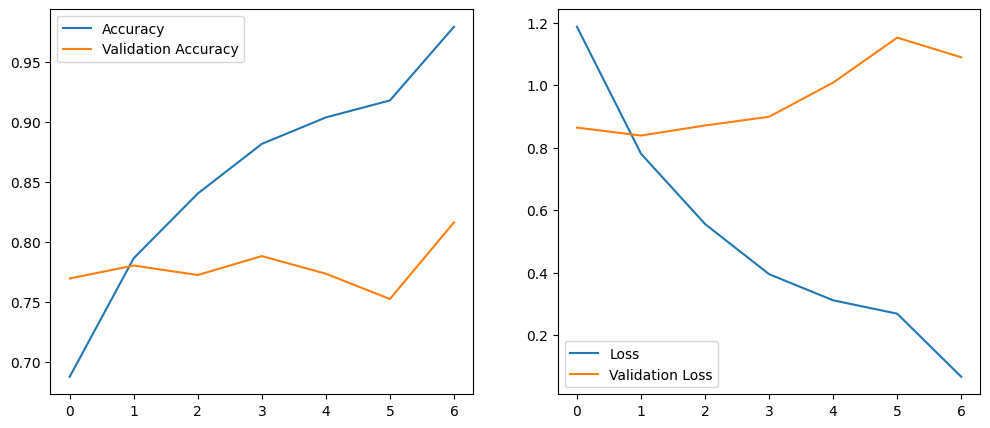

In [46]:
plot_curves(history_fine_tune)

### Build and Plot the Confusion Matrix

In [48]:
# since the test data is batched, we need to concatenate the predictions and true labels
# the predictions were out of order when we used model.predict(test_data), hence we had to resort to this method

pred = []
true = []
for image, target in test_data:
    pred.append(model.predict(image, verbose=0))
    true.append(target)

true = tf.concat(true, axis=0)
pred = tf.concat(pred, axis=0)
true, pred

(<tf.Tensor: shape=(25250,), dtype=int64, numpy=array([84, 60, 29, ..., 21,  3, 25])>,
 <tf.Tensor: shape=(25250, 101), dtype=float32, numpy=
 array([[9.2964031e-12, 3.2839922e-09, 3.7583302e-08, ..., 4.6020531e-12,
         1.7341842e-08, 1.3876095e-10],
        [5.4063062e-08, 8.6704760e-10, 1.9846917e-09, ..., 3.1298644e-06,
         3.7168058e-06, 1.1919002e-10],
        [5.6401017e-12, 4.6362766e-10, 1.1710902e-10, ..., 7.3859724e-11,
         1.1527621e-11, 5.1161141e-11],
        ...,
        [1.6156624e-08, 1.5978133e-17, 5.3151129e-12, ..., 5.5701906e-12,
         1.8573966e-16, 1.7203987e-19],
        [1.5798783e-24, 3.3962156e-13, 2.0426587e-17, ..., 3.6777167e-16,
         9.6255768e-08, 4.2996867e-16],
        [4.6019173e-32, 4.3347872e-27, 7.3760147e-38, ..., 8.5126906e-33,
         1.8459751e-28, 2.8445207e-23]], dtype=float32)>)

In [49]:
def plot_confusion_matrix(y_true, y_pred, class_names, figsize=(50, 50)):
    """
    Plots the confusion matrix, given the true labels and predicted scores.
    Saves the plot as a png file.
    
    :param y_true: 1-d array of true labels
    :param y_pred: array-like predictions of shape (n_samples, n_classes)
    :param class_names: 1-d array of class names
    :param figsize: tuple, size of the figure (width, height)
    :return: None
    """

    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    cm = confusion_matrix(y_true, tf.argmax(y_pred, axis=1))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=figsize)
    disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')

    disp.figure_.savefig('confusion_matrix.png')

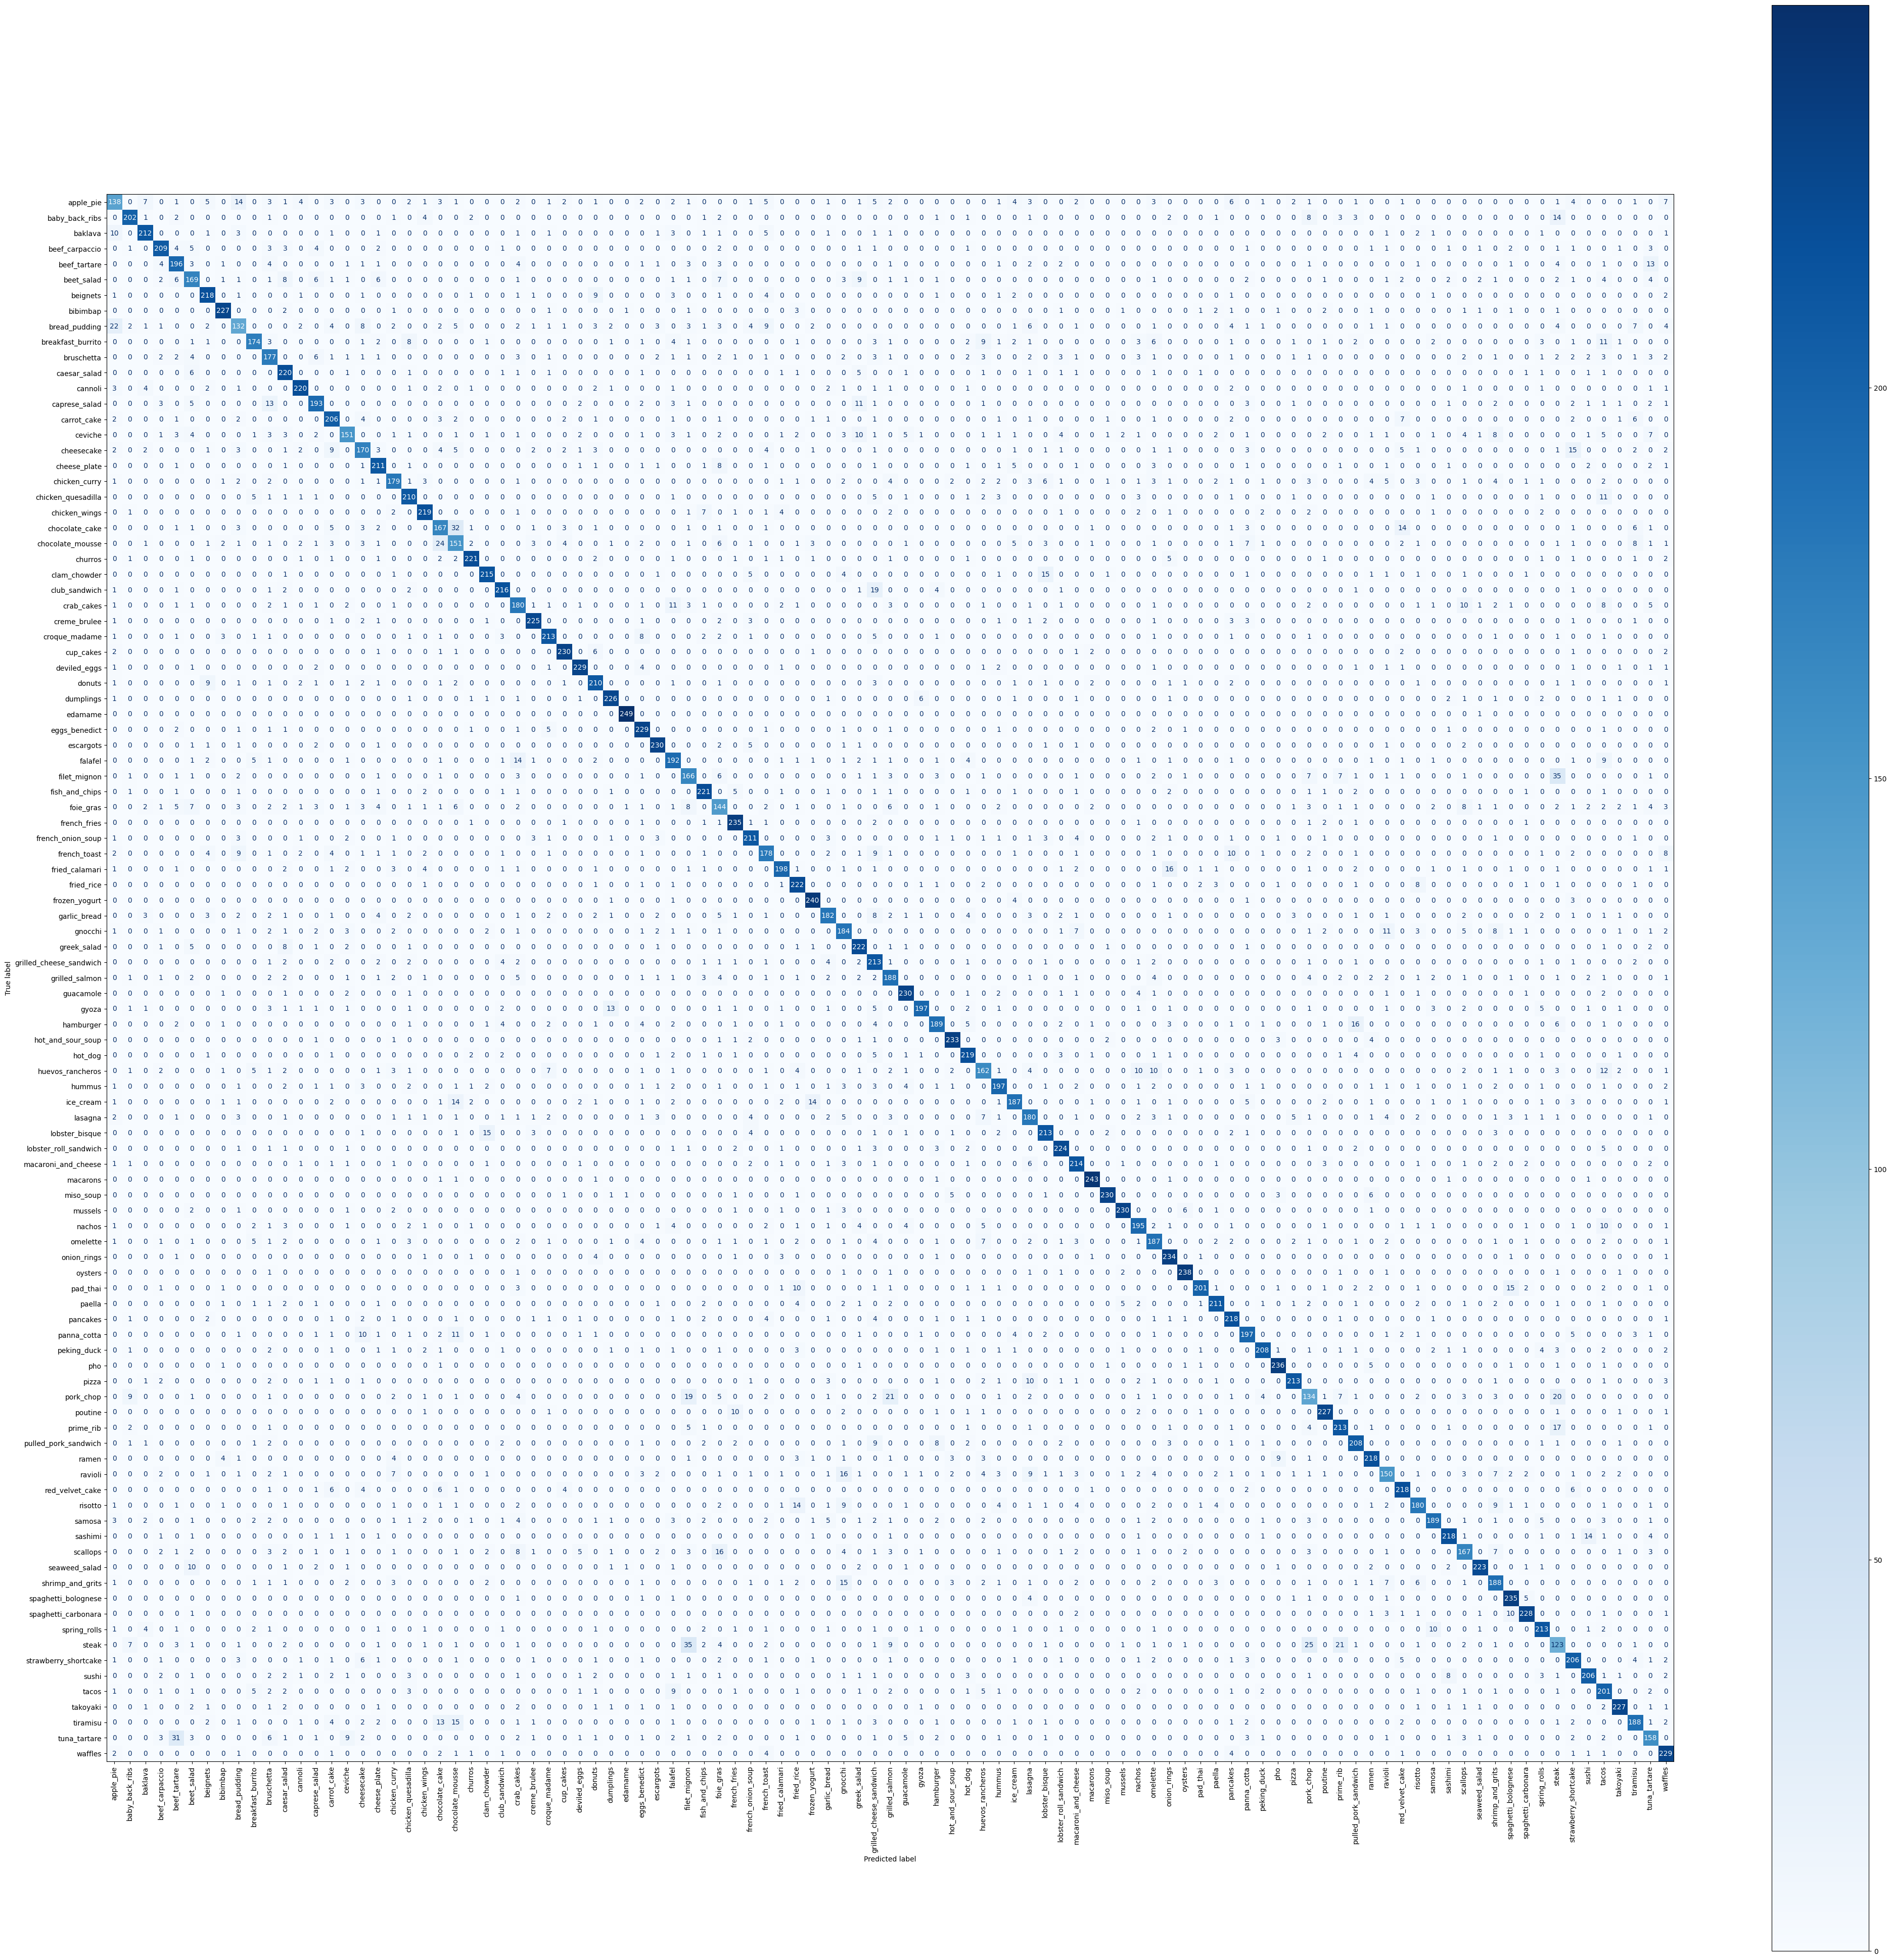

In [50]:
plot_confusion_matrix(true, pred, class_names)

### Display additional metrics

In [51]:
def display_overall_metrics(y_true, y_pred):
    """
    Displays overall metrics for the predictions.
    These include:
        - Accuracy
        - Top-5 Accuracy
        - F1 Score
        - Precision
        - Recall
    
    :param y_true: 1-d array of y_true labels
    :param y_pred: array-like of shape (n_samples, n_classes)
    :return: None
    """

    from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, top_k_accuracy_score

    print("Accuracy:", accuracy_score(y_true, tf.argmax(y_pred, axis=1)))
    print("Top-5 Accuracy:", top_k_accuracy_score(y_true, y_pred, k=5))

    print("F1 Score:", f1_score(y_true, tf.argmax(y_pred, axis=1), average='weighted'))
    print("Precision:", precision_score(y_true, tf.argmax(y_pred, axis=1), average='weighted'))
    print("Recall:", recall_score(y_true, tf.argmax(y_pred, axis=1), average='weighted'))

In [52]:
display_overall_metrics(true, pred)

Accuracy: 0.8100198019801981
Top-5 Accuracy: 0.9506930693069306
F1 Score: 0.8093477597150219
Precision: 0.811741776738269
Recall: 0.8100198019801981


In [55]:
def plot_class_scores(y_true, y_pred, class_names, figsize=(10, 30)):
    """
    Plots the F1, Precision and Recall scores for each class, in a horizontal bar chart.
    Saves the plots as png files.

    :param y_true: 1-d array of true labels
    :param y_pred: 1-d array of predicted labels
    :param class_names: 1-d array of class names
    :param figsize: tuple, size of the figure (width, height)
    :return: None
    """
    import matplotlib.pyplot as plot
    import pandas as pd
    from sklearn.metrics import classification_report

    classification_report = classification_report(y_true, y_pred, target_names=class_names,
                                                  output_dict=True)

    class_f1_score = {}
    class_precision = {}
    class_recall = {}

    for class_name in class_names:
        class_f1_score[class_name] = classification_report[class_name]['f1-score']
        class_precision[class_name] = classification_report[class_name]['precision']
        class_recall[class_name] = classification_report[class_name]['recall']

    class_f1_score = pd.DataFrame({
        'class': list(class_f1_score.keys()),
        'f1_score': list(class_f1_score.values()),
    }).sort_values(by='f1_score')

    class_precision = pd.DataFrame({
        'class': list(class_precision.keys()),
        'precision': list(class_precision.values()),
    }).sort_values(by='precision')

    class_recall = pd.DataFrame({
        'class': list(class_recall.keys()),
        'recall': list(class_recall.values()),
    }).sort_values(by='recall')

    class_f1_score.plot.barh(x='class', y='f1_score', title="Class wise F1 Score", figsize=figsize).figure.savefig(
        'f1_score.png')
    plot.show(block=True)

    class_precision.plot.barh(x='class', y='precision', title="Class wise Precision",
                              figsize=figsize, ).figure.savefig('precision.png')
    plot.show(block=True)

    class_recall.plot.barh(x='class', y='recall', title="Class wise Recall", figsize=figsize).figure.savefig(
        'recall.png')
    plot.show(block=True)

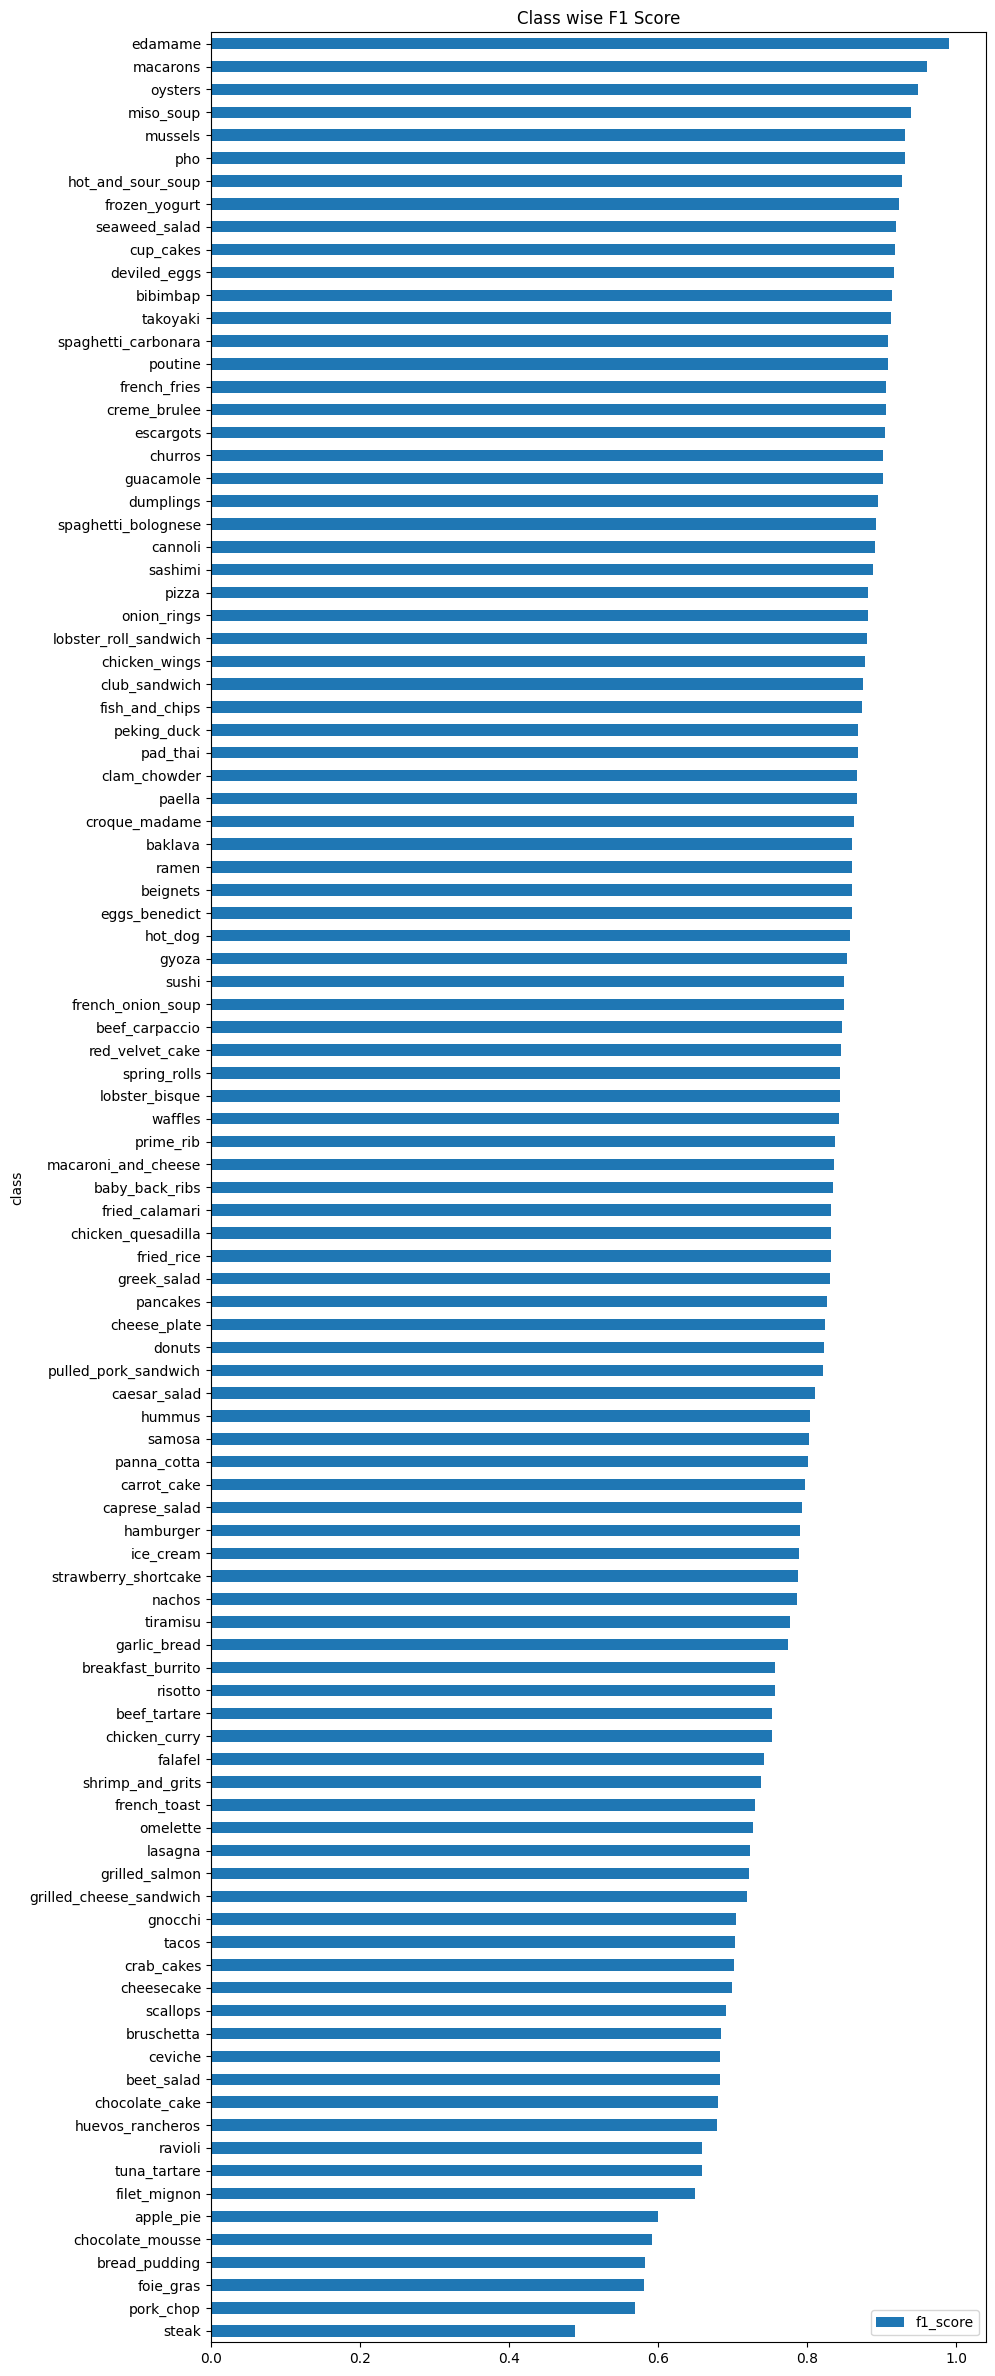

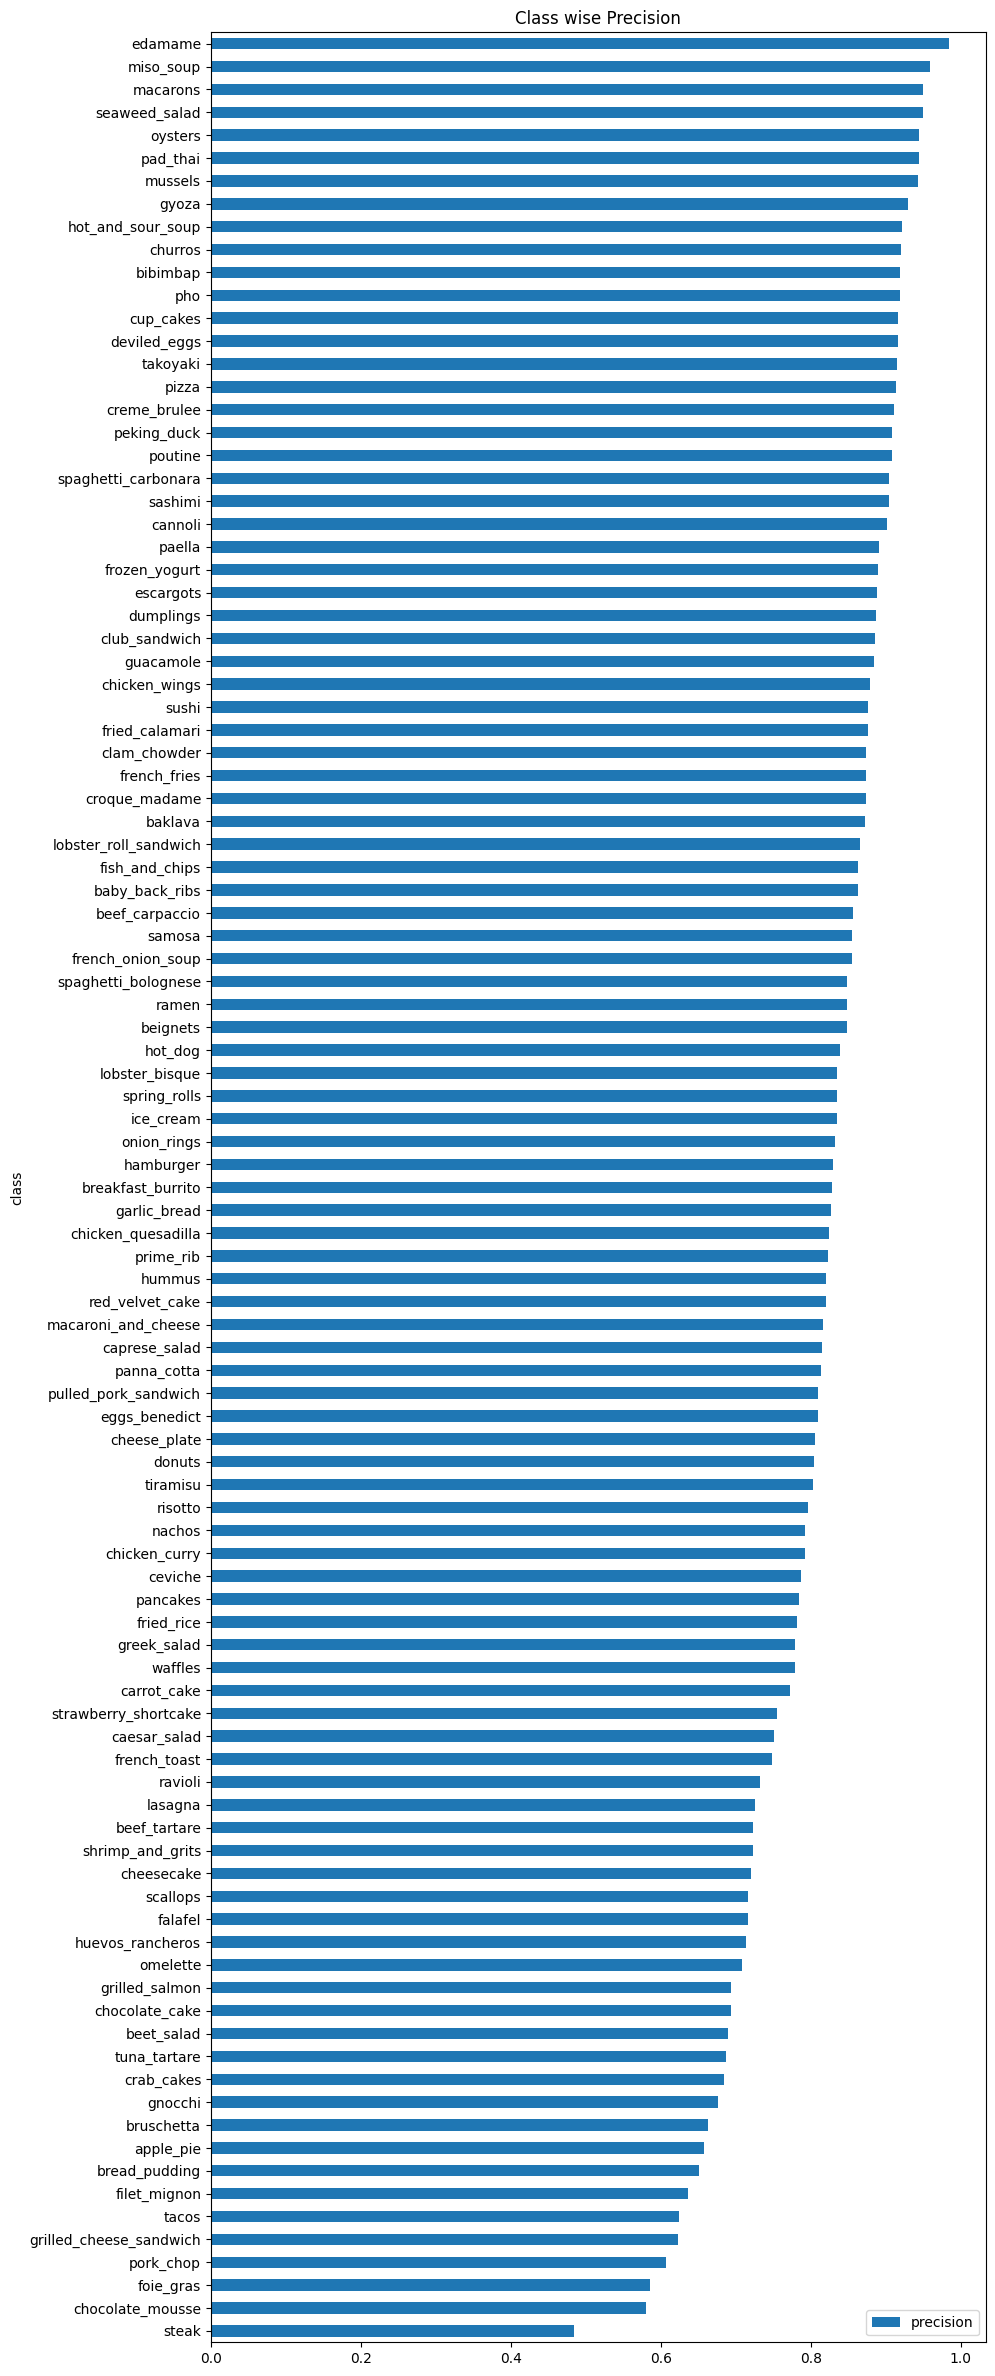

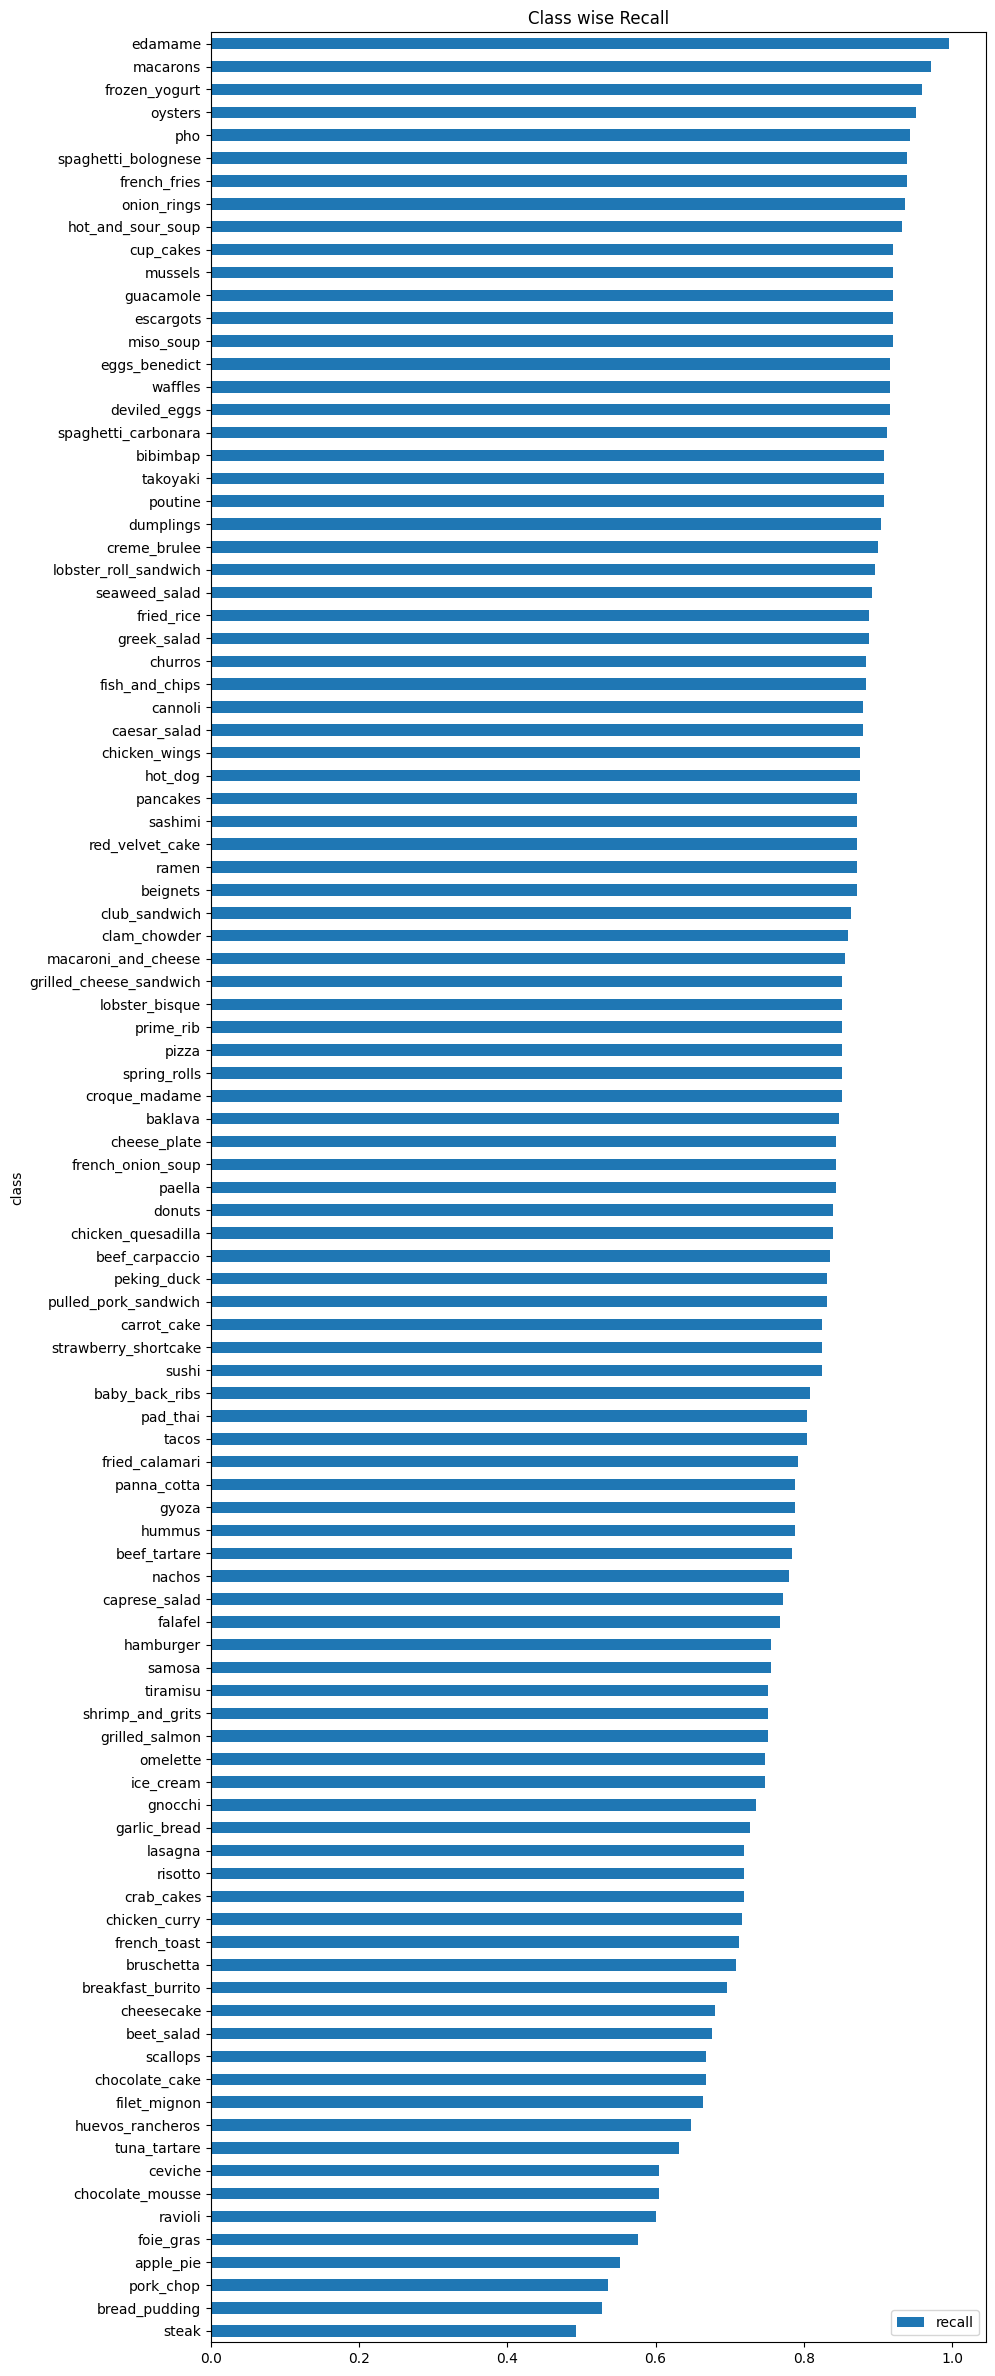

In [56]:
plot_class_scores(true, tf.argmax(pred, axis=1), class_names)

## Conclusion

We were able to achieve a top-1 accuracy of **81%** and a top-5 accuracy of **95%** on the test set, beating the results obtained by the [DeepFood Paper](https://arxiv.org/abs/1606.05675).

## Author

[Anikate De](https://github.com/Anikate-De)

- [Visit my Website](https://anikate-de.github.io/)
- [Connect on LinedIn](https://www.linkedin.com/in/anikate-de/)